# XGBoost con variables de las diferencias de medias ponderadas

* [Carga de los datos](#carga-de-los-datos)
* [Transformaciones](#transformaciones)
* [Selección de variables](#seleccion-de-variables)
* [Ajuste de hiperparámetros](#ajuste-de-hiperparametros)
* [Conclusiones](#conclusiones)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,log_loss, make_scorer, f1_score, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
import os
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import mlflow
import optuna

c:\Users\andre\OneDrive - Universidad Complutense de Madrid (UCM)\Escritorio\UNIVERSIDAD\2º\2º Cuatrimestre\PD1\c2425-R4\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Descripción general del notebook

En este notebook se llevará a cabo el modelado y entrenamiento de un modelo XGBoost con el propósito de predecir el ganador de una pelea. Para ello, se utilizarán las diferencias en las estadísticas medias de cada peleador como variables predictoras.

El objetivo principal es explorar alternativas que permitan mejorar el desempeño del modelo en comparación con la versión basada en medias ponderadas.

Dado que el proceso de transformación de datos, selección de variables y ajuste de hiperparámetros será similar al realizado en el otro notebook, estos aspectos no serán abordados en detalle en esta ocasión.

In [4]:
# ruta_mlflow = os.path.abspath(os.path.join("..", "..", "..", "mlruns"))

# # Configurar MLflow para guardar los modelos en esa ruta
# mlflow.set_tracking_uri(f"file:///{ruta_mlflow}")

# print("MLflow tracking URI:", mlflow.get_tracking_uri())  

Para guardar los resultados de diferentes experimentos creamos un directorio mlruns donde se guardarán los modelos realizados con una breve descripción y sus resultados.

### Carga de los datos

Cargamos el conjunto de train y test los cuales han sido seleccionados respetando el orden cronológico debido a que es una serie temporal. Separamos los conjuntos en X e y. En X guardamos todas las variables que puedan ser introducidas al modelo, excluyendo los nombres, la fecha y la variable respuesta. En y guardamos la variable respuesta.

In [2]:
#Leo los df divididos en orden cronológico de forma que los resultados sean lo más reales posibles
ruta_train =  os.path.join("..","..","..", "data", "P2_dif","train.parquet")
df_train = pd.read_parquet(ruta_train)
df_train.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF,...,Record_DIFF,Peleas_DIFF,Puntos_DIFF,Racha_DIFF,Victorias_KO_DIFF,Victorias_Sub_DIFF,Victorias_Decision_DIFF,Derrotas_KO_DIFF,Derrotas_Sub_DIFF,Derrotas_Decision_DIFF
0,2011-01-22,Melvin Guillard,Evan Dunham,False,0.24,0.1160,-0.475248,-3.16,0.80,-185.76,...,25.0,7,10.302760,3,3.6,-1.0,0.76,0.00,4.0,-0.36
1,2011-02-26,George Sotiropoulos,Dennis Siver,True,-0.12,-0.0364,0.081182,1.56,0.00,228.72,...,1.0,-3,3.779920,5,-2.0,2.0,1.00,-1.00,-1.0,-2.00
2,2011-03-19,Ricardo Almeida,Mike Pyle,True,-0.24,-0.0076,0.255163,-1.08,-0.24,238.92,...,-3.0,5,9.316743,-1,0.0,1.4,2.00,0.00,-0.4,1.00
3,2011-03-19,Mirko Filipovic,Brendan Schaub,True,-0.76,-0.1868,0.000000,0.88,0.00,143.08,...,-8.0,4,-8.023557,-3,1.4,0.6,-0.36,1.36,0.0,1.00
4,2011-03-19,Dan Miller,Nate Marquardt,True,0.00,-0.0880,0.093856,-0.92,-0.40,188.52,...,-14.0,-5,6.343023,2,-3.6,0.6,-1.64,-1.00,0.0,0.64


In [3]:
ruta_test = os.path.join("..","..","..","data", "P2_dif","test.parquet")
df_test = pd.read_parquet(ruta_test)
df_test.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF,...,Record_DIFF,Peleas_DIFF,Puntos_DIFF,Racha_DIFF,Victorias_KO_DIFF,Victorias_Sub_DIFF,Victorias_Decision_DIFF,Derrotas_KO_DIFF,Derrotas_Sub_DIFF,Derrotas_Decision_DIFF
0,2023-02-04,Derrick Lewis,Serghei Spivac,True,0.40,0.2228,-0.307248,-0.36,0.0,-136.44,...,4.0,16,109.248764,-2,11.04,-1.00,2.00,3.96,1.0,-1.00
1,2023-02-04,Dooho Choi,Kyle Nelson,True,0.36,-0.1728,0.133333,0.00,0.0,-61.20,...,4.0,1,0.000000,0,2.00,0.00,0.00,-0.64,-1.0,0.64
2,2023-02-04,Marcin Tybura,Blagoy Ivanov,False,0.00,-0.0780,-0.188071,-0.40,0.0,-56.72,...,1.0,10,139.896213,0,4.00,0.00,3.00,3.00,0.0,0.00
3,2023-02-11,Tyson Pedro,Modestas Bukauskas,True,0.60,0.2432,0.000000,0.40,0.0,16.88,...,-2.0,4,24.394312,2,0.96,2.00,0.00,-0.36,1.0,0.40
4,2023-02-11,Islam Makhachev,Alexander Volkanovski,False,0.12,0.0456,0.130692,1.16,-0.8,5.28,...,-2.0,1,-211.409548,-1,-2.00,5.36,-3.36,1.00,0.0,0.00


In [4]:
X_train = df_train.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_train = df_train["WINNER"]
y_train.value_counts(normalize=True)

WINNER
False    0.561973
True     0.438027
Name: proportion, dtype: float64

In [5]:
X_test = df_test.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_test = df_test["WINNER"]
y_test.value_counts(normalize=True)

WINNER
False    0.550505
True     0.449495
Name: proportion, dtype: float64

### Transformaciones

Para el modelo XGBoost no es necesario realizar transformaciones previas de las variables, como la normalización o estandarización. Como no tenemos variables categóricas, tampoco será necesario ningún tipo de codificación.

### Seleccion de variables

El modelo XGBoostClassifier no requiere una selección explícita de variables antes del entrenamiento. Cada nodo selecciona automáticamente la variable que proporciona la mayor ganancia de información o reducción de impureza. 

### Ajuste de hiperparametros

Para buscar una configuración óptima de hiperparámetros he utilizado dos estrategias, GridSearchCV y RandomizedSearchCV. 

### GridSearch

In [9]:
def train_xgboost_grid(X_train, y_train, X_val, y_val):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1
    tscv = TimeSeriesSplit(n_splits=5)
    # Definir modelo base
    xgb = XGBClassifier(random_state=42)


    param_grid = {
    'n_estimators': [100, 250],
    'learning_rate': [0.01, 0.05],  
    'subsample': [0.7, 1.0],  
    'colsample_bytree': [0.5, 0.7, 1.0],  # Añadir 0.5 para más regularización
    'gamma': [0, 0.1],  
    'min_child_weight': [10,35,50],  # Añadir 3 como punto intermedio 
    'reg_alpha': [0.1, 1.0], 
    'reg_lambda': [0.1, 1.0], 
    'scale_pos_weight': [1, scale_pos_weight]  
}


    # Definir la métrica de optimización como el F1-score macro
    f1_scorer = make_scorer(f1_score, average='macro')

    # Búsqueda con validación cruzada
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring=f1_scorer,
        cv=tscv,
        n_jobs=-1,
        verbose=2
    )

    # Entrenar el modelo
    grid_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", grid_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = grid_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))

    return grid_search.best_estimator_,grid_search.best_params_

In [10]:
# mlflow.set_experiment("Prueba con Puntos tipo elo XGBoost")

#### Entrenamiento usando ajuste de hiperparámetros

In [11]:
print("-- Entrenamiento usando ajuste de hiperparámetros con GridSearchCV --")
best_grid,best_params = train_xgboost_grid(X_train,y_train,X_test,y_test)


-- Entrenamiento usando ajuste de hiperparámetros con GridSearchCV --
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
Mejores parámetros: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.05, 'min_child_weight': 10, 'n_estimators': 100, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'scale_pos_weight': np.float64(1.2829643888354187), 'subsample': 1.0}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.61      0.61      0.61       327
        True       0.53      0.53      0.53       267

    accuracy                           0.57       594
   macro avg       0.57      0.57      0.57       594
weighted avg       0.57      0.57      0.57       594



#### Predicción con el conjunto de test

In [12]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = best_grid.predict(X_test)
y_val_prob = best_grid.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_val_pred))
f1_val = f1_score(y_test, y_val_pred)
roc_auc_val = roc_auc_score(y_test, y_val_prob)
precision_val = precision_score(y_test, y_val_pred)
recall_val = recall_score(y_test, y_val_pred)
log_loss_val = log_loss(y_test,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5740740740740741
F1-Score: 0.5271
AUC-ROC: 0.6043
Precisión: 0.5261
Sensibilidad: 0.5281
Log-loss: 0.6870351198218172


Los resultados obtenidos con el modelo XGBoost, tras el ajuste de hiperparámetros, no son óptimos. Las métricas indican que el modelo no logra una mejora significativa en comparación con una predicción aleatoria y, además, su rendimiento es inferior al del modelo basado en medias ponderadas.

In [13]:
# if mlflow.active_run():
#     mlflow.end_run()

# # Iniciar un nuevo experimento
# with mlflow.start_run(run_name="con k=25 y victorias/derrotas fuera de las medias, prueba con min_child_weight alto"):

#     # Guardar modelo en MLflow
#     mlflow.xgboost.log_model(best_grid, "modelo_xgboost")
#     mlflow.log_param("mejores_parametros", best_params)
#     mlflow.log_metric("accuracy", accuracy_score(y_test, y_val_pred))
#     mlflow.log_metric("f1_macro", f1_val)

#     print("Modelo guardado en MLflow")

Esta celda la utilizamos para guardar el modelo y poder saber cual fue el que mejor nos funcionó cuando los comparemos.

#### Matriz de confusión

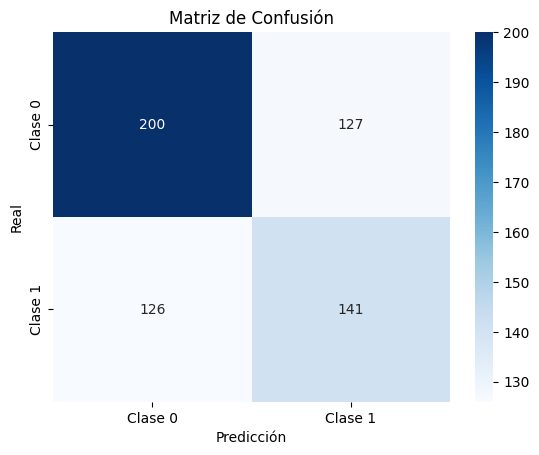

In [14]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

Si nos fijamos en la matriz de confusión, hay un gran número de falsos positivos y falsos negativos. Por lo que  el modelo no llega a clasificar de forma adecuada cada observación.

#### Importancia de cada variable

Se observa que la variable con mayor peso en la predicción es Racha_DIFF, lo que sugiere que la diferencia en las rachas de victorias entre ambos peleadores es un factor determinante al momento de predecir el ganador de la pelea. 

Por otro lado, variables como STR_GROUND_A_DIFF (diferencia en golpes significativos en el suelo) y Puntos_DIFF (diferencia en los puntos obtenidos) presentan una importancia similar y considerable.

In [15]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_grid.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

                    Feature  Importance
20               Racha_DIFF    0.070153
26   Derrotas_Decision_DIFF    0.044899
9           STR_HEAD_A_DIFF    0.043420
16            GRAPPLER_DIFF    0.043046
4                  REV_DIFF    0.039072
24         Derrotas_KO_DIFF    0.038455
25        Derrotas_Sub_DIFF    0.038347
14        STR_GROUND_A_DIFF    0.037180
6              TD_PORC_DIFF    0.036993
13        STR_CLINCH_A_DIFF    0.036968
19              Puntos_DIFF    0.036739
2                   TD_DIFF    0.036589
12      STR_DISTANCE_A_DIFF    0.036366
8                 TD_A_DIFF    0.034767
7          TOTAL_STR_A_DIFF    0.034745
15             STRIKER_DIFF    0.034718
21        Victorias_KO_DIFF    0.034150
10          STR_BODY_A_DIFF    0.033982
1              SIG_STR_DIFF    0.033741
0                   KD_DIFF    0.033646
11           STR_LEG_A_DIFF    0.033089
5                 CTRL_DIFF    0.032869
3              SUB_ATT_DIFF    0.031780
18              Peleas_DIFF    0.031725


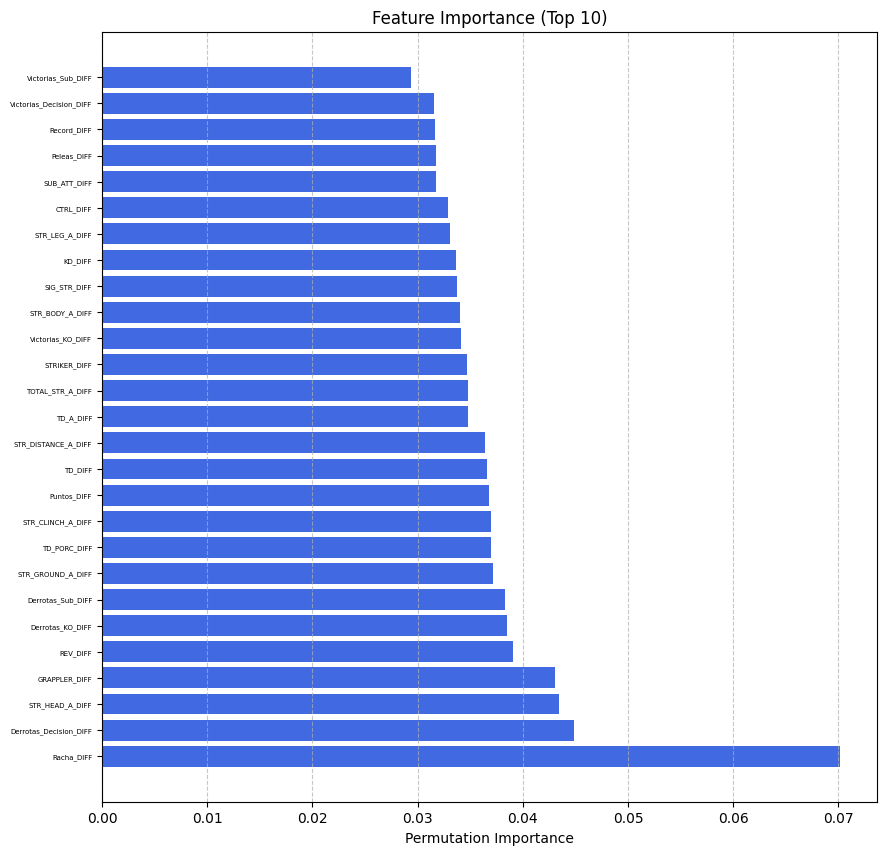

In [16]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Top 10)")
plt.yticks(fontsize=5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

#### Random Search

In [17]:
def train_xgboost_random(X_train, y_train, X_val, y_val):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1
    tscv = TimeSeriesSplit(n_splits=5)
    # Definir modelo base
    xgb = XGBClassifier(random_state=42)

    # Distribución de hiperparámetros para búsqueda aleatoria
    """
    param_dist = {
        'n_estimators': np.arange(50, 400, 50),
        'max_depth': np.arange(3, 60, 3),
        'learning_rate': np.linspace(0.01, 0.2, 10),
        'subsample': np.linspace(0.5, 1.0, 6),
        'colsample_bytree': np.linspace(0.5, 1.0, 6),
        'gamma': np.linspace(0, 0.5, 6),
        'min_child_weight': np.arange(1, 70, 2),
        'scale_pos_weight': [1, scale_pos_weight]
    }"
    """
    
    param_dist = {
        'n_estimators': np.arange(50, 400, 50),
        'max_depth': np.arange(3, 40, 2),
        'learning_rate': np.linspace(0.005, 0.2, 15),
        'subsample': np.linspace(0.5, 1.0, 6),
        'colsample_bytree': np.linspace(0.5, 1.0, 6),
        'gamma': np.linspace(0, 0.5, 6),
        'min_child_weight': np.arange(1, 70, 2),
        'scale_pos_weight': [1, scale_pos_weight],
        'reg_alpha': [0, 0.1, 0.5, 1], #Parámetro regularización
        'tree_method': ['auto', 'exact', 'approx', 'hist'], #Método construcción árbol
        'grow_policy': ['depthwise', 'lossguide'] #Política crecimiento árbol
    }

    # Definir la métrica de optimización como el F1-score macro
    f1_scorer = make_scorer(f1_score, average='macro')
    # Búsqueda con validación cruzada
    random_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        scoring=f1_scorer,
        n_iter=50,
        cv=tscv,
        n_jobs=-1,
        verbose=2,
        random_state=42
    )

    # Entrenar el modelo
    random_search.fit(X_train, y_train)

    # Imprimir mejores parámetros
    print("Mejores parámetros:", random_search.best_params_)

    # Evaluar el mejor modelo en el conjunto de validación
    y_pred = random_search.best_estimator_.predict(X_val)
    print("Reporte de clasificación:")
    print(classification_report(y_val, y_pred))


    return random_search

#### Entrenamiento usando ajuste de hiperparámetros

In [18]:
print("-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --")
resultados_random = train_xgboost_random(X_train,y_train,X_test,y_test)
best_random = resultados_random.best_estimator_
results_cv = resultados_random.cv_results_

-- Entrenamiento usando ajuste de hiperparámetros con RandomizedSeachCV --
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Mejores parámetros: {'tree_method': 'hist', 'subsample': np.float64(0.8), 'scale_pos_weight': np.float64(1.2829643888354187), 'reg_alpha': 0.1, 'n_estimators': np.int64(200), 'min_child_weight': np.int64(29), 'max_depth': np.int64(13), 'learning_rate': np.float64(0.046785714285714285), 'grow_policy': 'lossguide', 'gamma': np.float64(0.0), 'colsample_bytree': np.float64(0.8)}
Reporte de clasificación:
              precision    recall  f1-score   support

       False       0.61      0.60      0.60       327
        True       0.52      0.54      0.53       267

    accuracy                           0.57       594
   macro avg       0.57      0.57      0.57       594
weighted avg       0.57      0.57      0.57       594



#### Predicción con el conjunto de test

In [19]:
print("-- Métricas del modelo con hiperparámetros ajustados --")
y_val_pred = best_random.predict(X_test)
y_val_prob = best_random.predict_proba(X_test)[:,1]
print("Accuracy:", accuracy_score(y_test, y_val_pred))
f1_val = f1_score(y_test, y_val_pred)
roc_auc_val = roc_auc_score(y_test, y_val_prob)
precision_val = precision_score(y_test, y_val_pred)
recall_val = recall_score(y_test, y_val_pred)
log_loss_val = log_loss(y_test,y_val_prob)
print(f"F1-Score: {f1_val:.4f}")
print(f"AUC-ROC: {roc_auc_val:.4f}")
print(f"Precisión: {precision_val:.4f}")
print(f"Sensibilidad: {recall_val:.4f}")
print(f"Log-loss: {log_loss_val}")
print(confusion_matrix(y_test, y_val_pred))

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5707070707070707
F1-Score: 0.5304
AUC-ROC: 0.5991
Precisión: 0.5217
Sensibilidad: 0.5393
Log-loss: 0.6928582728099415
[[195 132]
 [123 144]]


El modelo obtenido mediante Random Search ha mostrado un rendimiento inferior al modelo ajustado con Grid Search. En particular, el accuracy obtenido es menor que el de una estrategia trivial que siempre predice la clase mayoritaria, la cual alcanzaría un 54.61% de accuracy.

#### Matriz de confusión

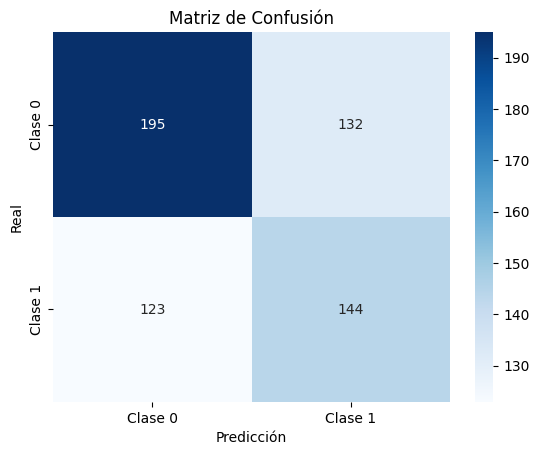

In [20]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

Ocurre algo similar al modelo con GridSearh, donde hay un gran número de falsos positivos y negativos.

#### Importancia de cada variable

In [21]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_random.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

                    Feature  Importance
20               Racha_DIFF    0.064153
19              Puntos_DIFF    0.040751
18              Peleas_DIFF    0.038826
9           STR_HEAD_A_DIFF    0.038799
7          TOTAL_STR_A_DIFF    0.038768
26   Derrotas_Decision_DIFF    0.038737
14        STR_GROUND_A_DIFF    0.038232
24         Derrotas_KO_DIFF    0.037847
16            GRAPPLER_DIFF    0.037108
12      STR_DISTANCE_A_DIFF    0.037067
2                   TD_DIFF    0.036361
25        Derrotas_Sub_DIFF    0.036241
3              SUB_ATT_DIFF    0.036194
11           STR_LEG_A_DIFF    0.036094
8                 TD_A_DIFF    0.036043
1              SIG_STR_DIFF    0.035745
13        STR_CLINCH_A_DIFF    0.035710
17              Record_DIFF    0.035562
5                 CTRL_DIFF    0.035288
10          STR_BODY_A_DIFF    0.034264
15             STRIKER_DIFF    0.033858
4                  REV_DIFF    0.033662
22       Victorias_Sub_DIFF    0.033527
6              TD_PORC_DIFF    0.033247


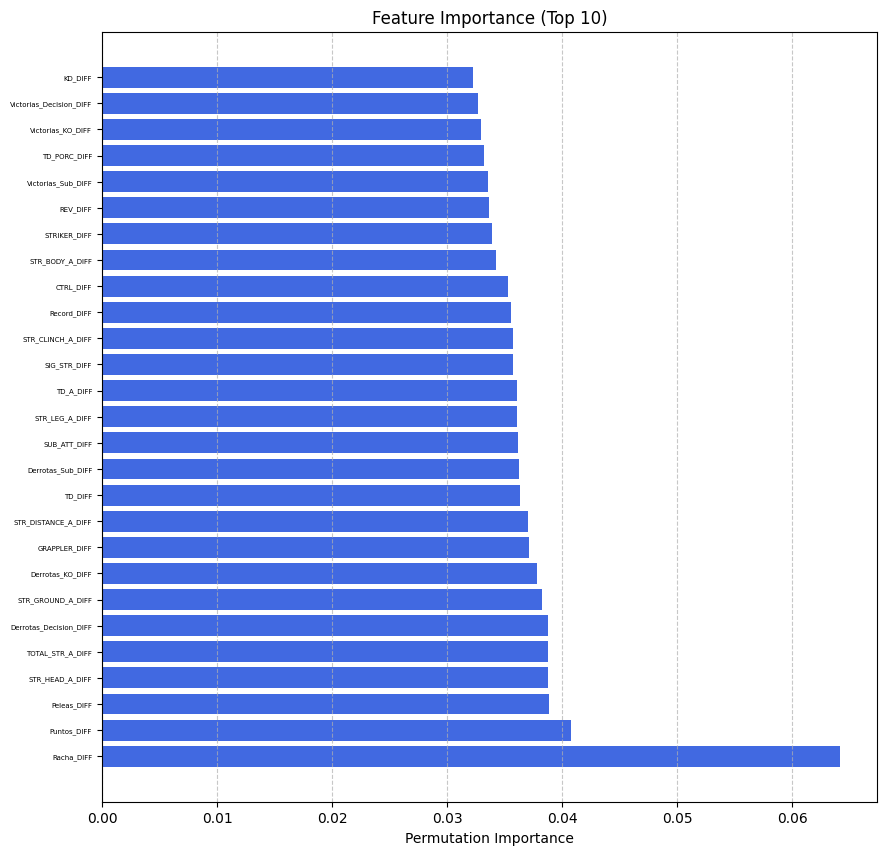

In [22]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Top 10)")
plt.yticks(fontsize=5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

#### Optuna

In [17]:
import numpy as np
import optuna
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

def objective(trial, X_train, y_train):
    # Calcular pesos de clase para manejar desbalance de datos
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else 1

    params = {
    'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=50),
    'max_depth': trial.suggest_int('max_depth', 3, 49, step=2),  # Ajustado de 40 a 39
    'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
    'subsample': trial.suggest_float('subsample', 0.6, 1.0),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    'gamma': trial.suggest_float('gamma', 0, 1.0),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 69, step=2),  
    'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1, scale_pos_weight]),
    'reg_alpha': trial.suggest_categorical('reg_alpha', [0, 0.1, 0.5, 1]),
    'tree_method': trial.suggest_categorical('tree_method', ['auto', 'exact', 'approx', 'hist']),
    'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
    'random_state': 42
}

    # Validación cruzada con series temporales
    tscv = TimeSeriesSplit(n_splits=5)
    model = XGBClassifier(**params)
    optuna.logging.set_verbosity(optuna.logging.INFO)
    scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='f1_macro', n_jobs=-1)
    return np.mean(scores)  # Retornamos el F1-score promedio


In [18]:
print("-- Entrenamiento usando ajuste de hiperparámetros con Optuna --")
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=200)

best_params = study.best_params
best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

print("Mejores parámetros:", best_params)

[I 2025-03-25 12:15:48,172] A new study created in memory with name: no-name-23bddf18-896e-45f0-a4ec-4bdd33968e97


-- Entrenamiento usando ajuste de hiperparámetros con Optuna --


[I 2025-03-25 12:15:51,970] Trial 0 finished with value: 0.5280066336443415 and parameters: {'n_estimators': 300, 'max_depth': 25, 'learning_rate': 0.045110500821707186, 'subsample': 0.8184123513513883, 'colsample_bytree': 0.5079848671644237, 'gamma': 0.41982541700318876, 'min_child_weight': 29, 'scale_pos_weight': np.float64(1.2829643888354187), 'reg_alpha': 0, 'tree_method': 'exact', 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.5280066336443415.
[I 2025-03-25 12:15:55,171] Trial 1 finished with value: 0.5126363284553135 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.07859319423013802, 'subsample': 0.802420085103331, 'colsample_bytree': 0.8971574775841971, 'gamma': 0.011918560424598046, 'min_child_weight': 13, 'scale_pos_weight': 1, 'reg_alpha': 1, 'tree_method': 'approx', 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.5280066336443415.
[I 2025-03-25 12:15:58,880] Trial 2 finished with value: 0.5024244887059408 and parameters: {'n_es

Mejores parámetros: {'n_estimators': 250, 'max_depth': 37, 'learning_rate': 0.032644311317957905, 'subsample': 0.6343124298039644, 'colsample_bytree': 0.750857944143133, 'gamma': 0.6114676621450115, 'min_child_weight': 17, 'scale_pos_weight': np.float64(1.2829643888354187), 'reg_alpha': 0.5, 'tree_method': 'hist', 'grow_policy': 'lossguide'}


In [19]:
y_val_pred = best_model.predict(X_test)
y_val_prob = best_model.predict_proba(X_test)[:,1]

print("-- Métricas del modelo con hiperparámetros ajustados --")
print("Accuracy:", accuracy_score(y_test, y_val_pred))
print(f"F1-Score: {f1_score(y_test, y_val_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_val_prob):.4f}")
print(f"Precisión: {precision_score(y_test, y_val_pred):.4f}")
print(f"Sensibilidad: {recall_score(y_test, y_val_pred):.4f}")
print(f"Log-loss: {log_loss(y_test, y_val_prob):.4f}")

-- Métricas del modelo con hiperparámetros ajustados --
Accuracy: 0.5774410774410774
F1-Score: 0.5255
AUC-ROC: 0.5880
Precisión: 0.5305
Sensibilidad: 0.5206
Log-loss: 0.7007


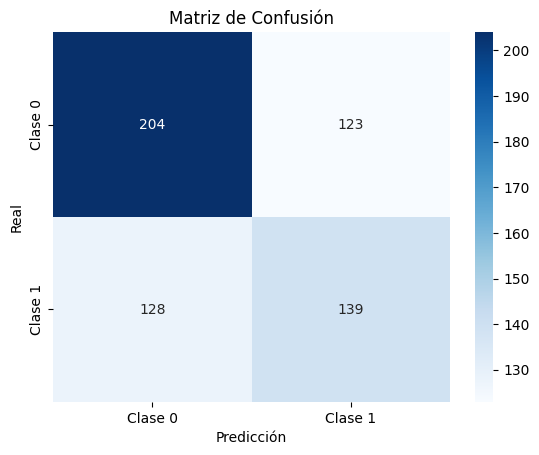

In [21]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_val_pred)

# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importance)

                    Feature  Importance
20               Racha_DIFF    0.056858
24         Derrotas_KO_DIFF    0.040765
19              Puntos_DIFF    0.040443
25        Derrotas_Sub_DIFF    0.038262
9           STR_HEAD_A_DIFF    0.038072
1              SIG_STR_DIFF    0.038012
7          TOTAL_STR_A_DIFF    0.037850
4                  REV_DIFF    0.037739
26   Derrotas_Decision_DIFF    0.037520
10          STR_BODY_A_DIFF    0.037254
0                   KD_DIFF    0.036969
18              Peleas_DIFF    0.036686
3              SUB_ATT_DIFF    0.036398
2                   TD_DIFF    0.036383
13        STR_CLINCH_A_DIFF    0.036223
8                 TD_A_DIFF    0.035904
16            GRAPPLER_DIFF    0.035562
14        STR_GROUND_A_DIFF    0.035488
6              TD_PORC_DIFF    0.035328
21        Victorias_KO_DIFF    0.035239
11           STR_LEG_A_DIFF    0.035006
5                 CTRL_DIFF    0.033951
15             STRIKER_DIFF    0.033914
22       Victorias_Sub_DIFF    0.033793


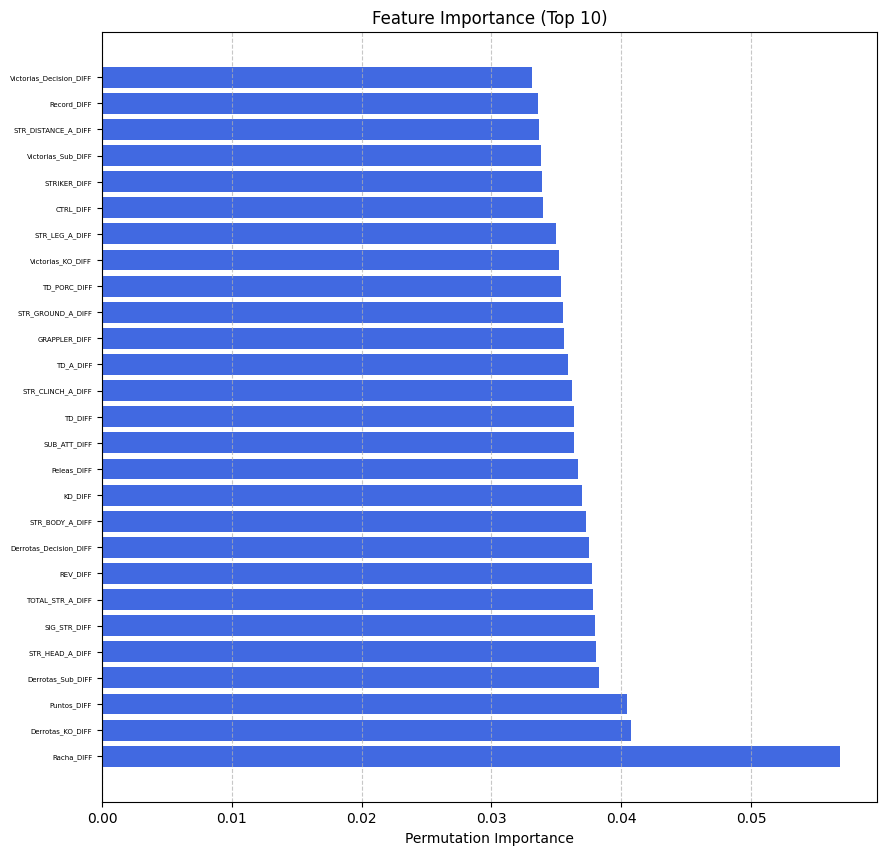

In [23]:
plt.figure(figsize=(10, 10))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="royalblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance (Top 10)")
plt.yticks(fontsize=5)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

#### Conclusiones
Tras evaluar los resultados del modelo utilizando dos enfoques de ajuste de hiperparámetros, se concluye que Grid Search logra un rendimiento ligeramente superior a la simple predicción de la clase mayoritaria. Sin embargo, su accuracy sigue siendo inferior al del modelo XGBoost basado en medias ponderadas, lo que indica que la estrategia de diferencias de estadísticas no ha mejorado la capacidad predictiva del modelo.